In [1]:
# Import dependencies
import requests
import pandas as pd
from dotenv import load_dotenv
import os
import json
import datetime as dt
import time
from prophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline

# Load environment variables and Exchange Rate API key
load_dotenv()
API_KEY = os.getenv("EXCHANGE_RATE_API_KEY")


In [2]:
# Save config information.
BASE_URL = "https://v6.exchangerate-api.com/v6"

# Set base currency and other currencies to convert to
BASE_CURRENCY = 'USD'
#CURRENCIES = ['EUR', 'AUD', 'JPY', 'CLP', 'IDR', 'CNY']
CURRENCIES = ['EUR', 'AUD']

In [3]:
def fetch_historical_rates(date):
    """Fetch historical exchange rates for a specific date."""
    url = f"{BASE_URL}/{API_KEY}/history/{BASE_CURRENCY}/{date}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

def create_time_series_data():
    """Create time series data for the last 3 years."""
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=3*365)
    
    data = []
    current_date = start_date
    
    while current_date <= end_date:
        date_str = current_date.strftime('%Y/%m/%d')
        rates = fetch_historical_rates(date_str)
        
        if rates and 'conversion_rates' in rates:
            for CURRENCY in CURRENCIES:
                if CURRENCY in rates['conversion_rates']:
                    data.append({
                        'date': date_str,
                        'currency': CURRENCY,
                        'rate': rates['conversion_rates'][CURRENCY]
                    })
        
        # Add delay to respect API rate limits
        time.sleep(1)
        current_date += dt.timedelta(days=30)
    
    return pd.DataFrame(data)

def prepare_prophet_data(df, CURRENCY):
    """Prepare data for Prophet forecasting."""
    currency_data = df[df['currency'] == CURRENCY].copy()
    currency_data = currency_data.rename(columns={'date': 'ds', 'rate': 'y'})
    return currency_data

def forecast_rates(df, CURRENCY, periods=30):
    """Generate forecasts using Prophet."""
    prophet_data = prepare_prophet_data(df, CURRENCY)
    
    model = Prophet(yearly_seasonality=True,
                   weekly_seasonality=True,
                   daily_seasonality=False,
                   changepoint_prior_scale=0.05)
    
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    return forecast

def plot_historical_rates(df):
    """Plot historical exchange rates."""
    plt.figure(figsize=(15, 8))
    for CURRENCY in CURRENCIES:
        currency_data = df[df['currency'] == CURRENCY]
        plt.plot(pd.to_datetime(currency_data['date']), 
                currency_data['rate'], 
                label=f'{BASE_CURRENCY}/{CURRENCY}')
    
    plt.title('Historical Exchange Rates (Last 3 Years)')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_forecast(forecast, CURRENCY):
    """Plot Prophet forecast."""
    plt.figure(figsize=(15, 8))
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.fill_between(forecast['ds'], 
                    forecast['yhat_lower'], 
                    forecast['yhat_upper'], 
                    alpha=0.3)
    plt.title(f'{BASE_CURRENCY}/{CURRENCY} Exchange Rate Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



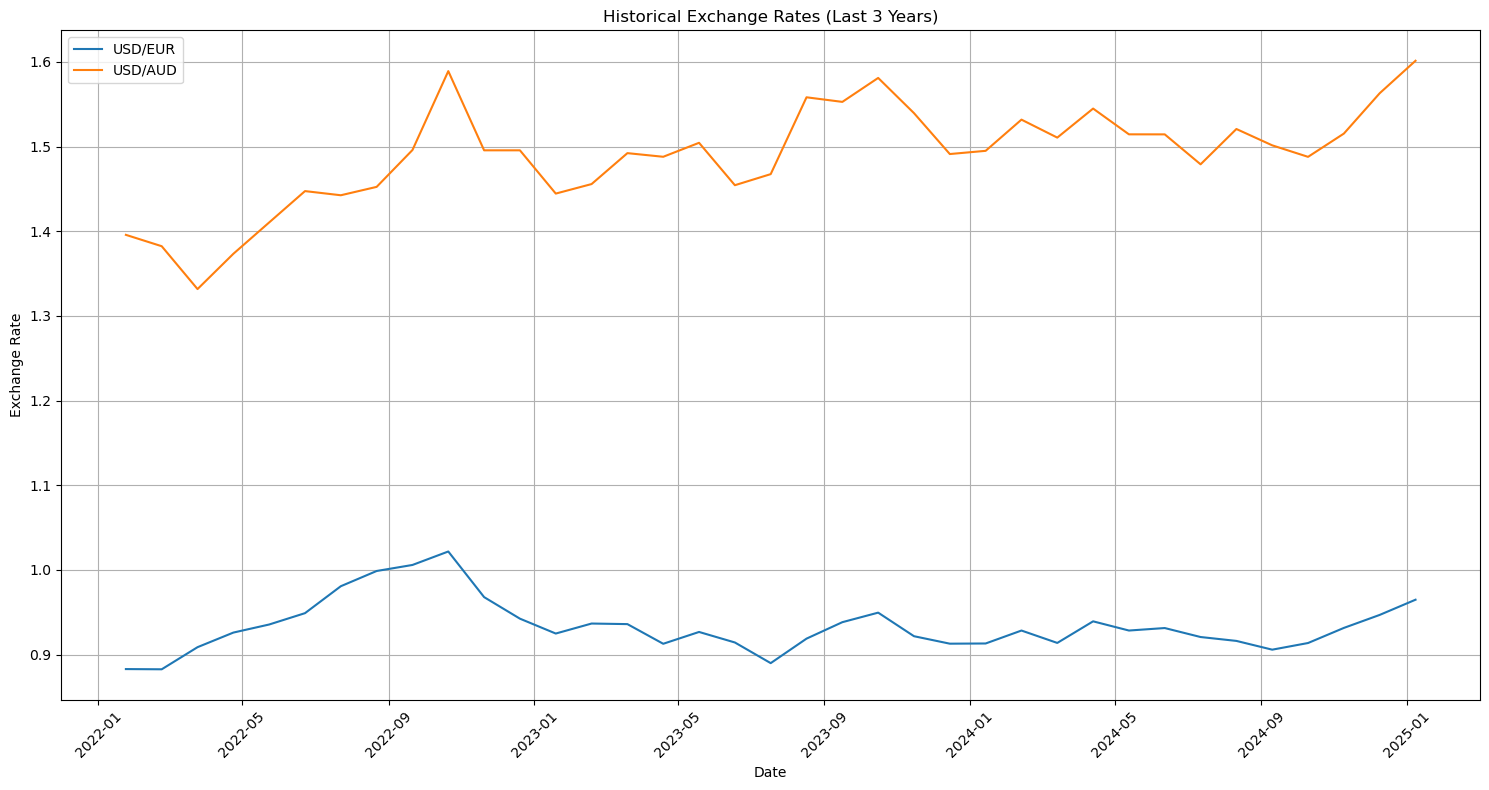

13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] done processing


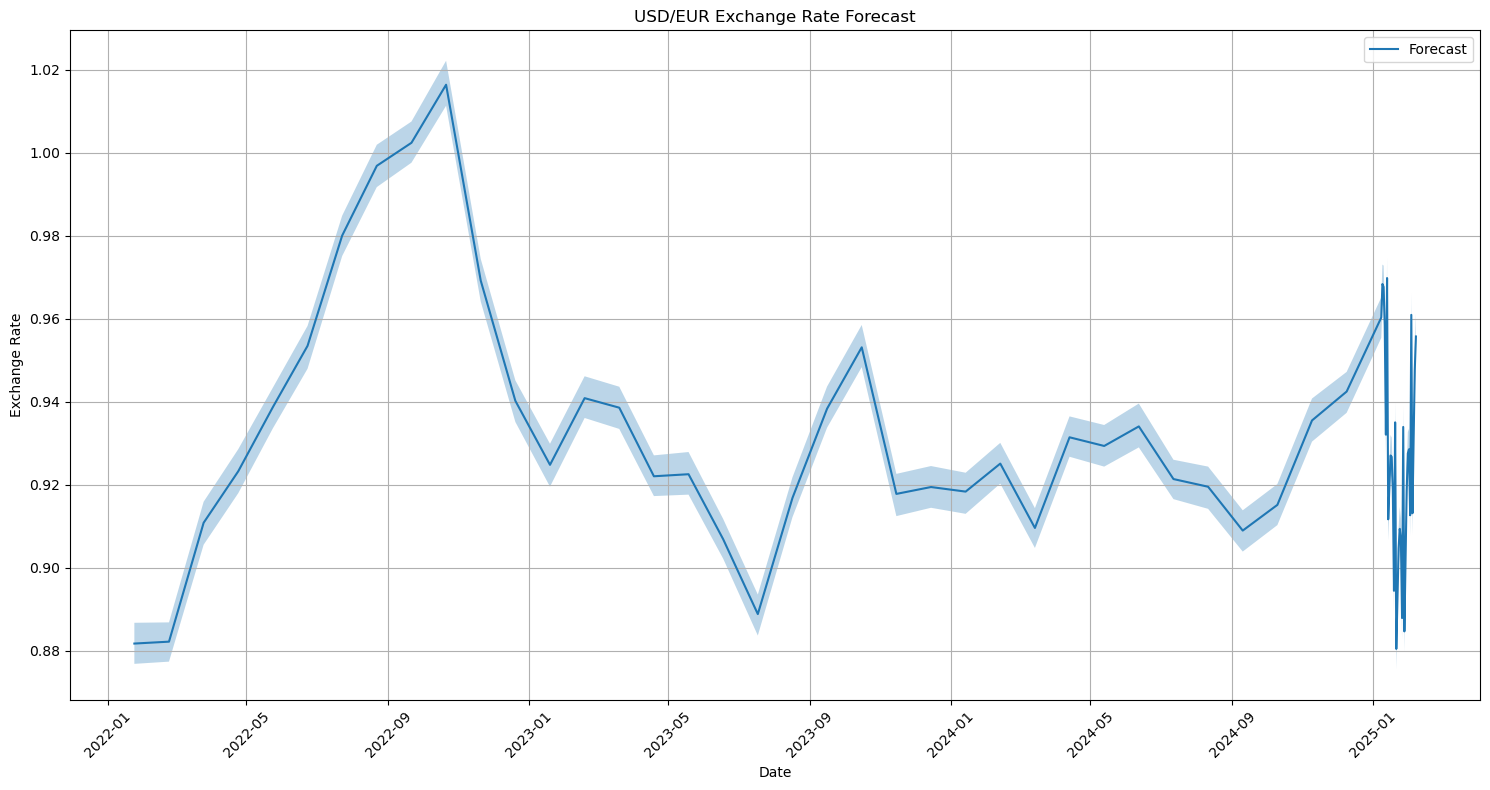

13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] done processing



Forecast Summary for USD/EUR:
           ds      yhat  yhat_lower  yhat_upper
62 2025-02-03  0.960923    0.956196    0.966199
63 2025-02-04  0.913103    0.907850    0.918364
64 2025-02-05  0.930834    0.925766    0.936043
65 2025-02-06  0.947664    0.942625    0.952862
66 2025-02-07  0.955713    0.950384    0.961218


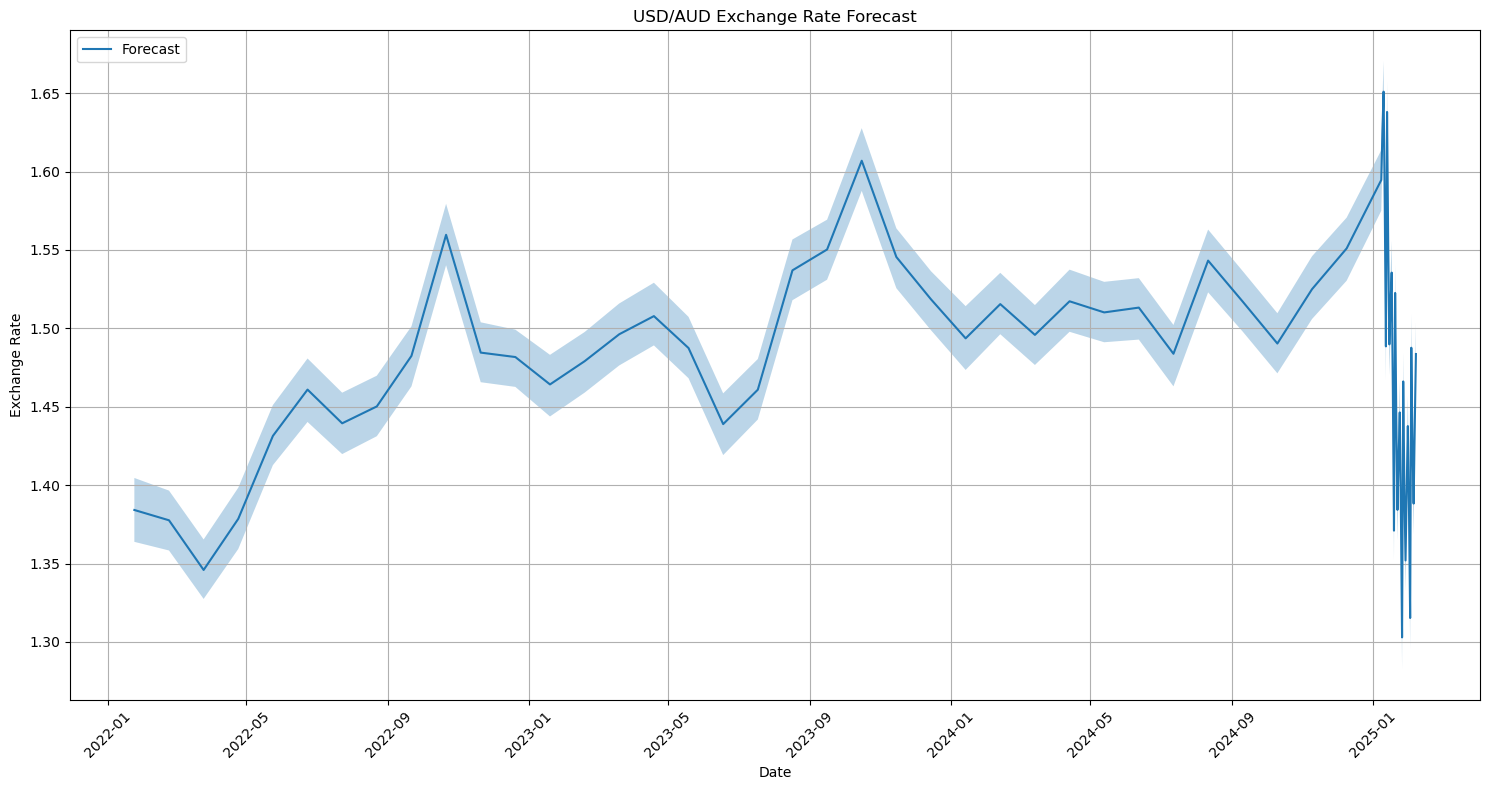


Forecast Summary for USD/AUD:
           ds      yhat  yhat_lower  yhat_upper
62 2025-02-03  1.487615    1.469174    1.509318
63 2025-02-04  1.427008    1.408699    1.447756
64 2025-02-05  1.388221    1.368468    1.407430
65 2025-02-06  1.438387    1.418218    1.456395
66 2025-02-07  1.483612    1.464610    1.503900


In [4]:
# Main execution
if __name__ == "__main__":
    # Fetch historical data
    df = create_time_series_data()
    
    # Plot historical rates
    plot_historical_rates(df)
    
    # Generate and plot forecasts for each currency
    for CURRENCY in CURRENCIES:
        forecast = forecast_rates(df, CURRENCY)
        plot_forecast(forecast, CURRENCY)
        
        # Print forecast summary
        print(f"\nForecast Summary for {BASE_CURRENCY}/{CURRENCY}:")
        print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())